In [4]:
import numpy as np
import json
import pandas as pd
import json
import os
import os
import json


def remove_underline(x):
    return x.replace("_", "")

# read the output logs file
with open('/home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/logs', 'r') as file:
    data = file.readlines()
data = [ json.loads(x) for x in data]
print(data)

In [5]:
BASE_PATH = '/home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/'
commands = []
data = []

NSHOTS=24
shot_num = NSHOTS
# iter_name = "iter-380000-ckpt-step-47500_hf"
# size="1b"

high_priority=False
# iter_name = "iter-160000-ckpt-step-40000_hf"
# size="360M"
# iter_name = "iter-240000-ckpt-step-60000_hf"
# size="120M"
iter_name = "iter-380000-ckpt-step-47500_hf"
size="1b"



TASK_CLASS="icl"

class_to_tasks_mapping = {"icl": ['agnews' ,'amazon' ,'dbpedia' ,'sst2' ,'tweet_hate' ,'tweet_offensive' ,'yelp' ],
                          "obqa": [ "squad", "nq_obqa", "tq_obqa" ,"hotpotqa"],
                          "cbqa": ["tq", "nq"]
                          }

class_to_seed_mapping = {"icl": range(42, 58),
                         "obqa": range(42, 46+1),
                         "cbqa": range(42, 46 + 1)
                         }
for task_name in  class_to_tasks_mapping[TASK_CLASS]:
    for model_name in ['cc', 'cc_merged_v1', 'cc_merged_v2' ,'cc_merged_v3']:
    # for model_name in ['bstilm']:
        # for seed_num in range(42, 46 + 1):
        for seed_num in class_to_seed_mapping[TASK_CLASS]:
            full_name = f"tiny_LLaMA_{size}_8k_{model_name}_8k-{iter_name}"
            # full_name = "TinyLlama/TinyLlama-1.1B-step-50K-105b"
            result_path = os.path.join(BASE_PATH,full_name, f'{task_name}_{shot_num}_{seed_num}.json')
            if not os.path.exists(result_path):
                print(f"File {result_path} does not exist")
                # curr = f""" sailctl job create eval1b{remove_underline(task_name)}{remove_underline(model_name)}{seed_num} -g 1  --debug --image asia-docker.pkg.dev/sail-tpu-02/git-insea-io/common/image_registry/liuqian/tinyllama:v9   --command-line-args  ' bash /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/ ; bash single_task.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_{model_name}_8k/{iter_name} {task_name} {seed_num} ' """
                if '1b' not in size:
                    model_path = f"tyzhu/tiny_LLaMA_{size}_8k_{model_name}_8k_{iter_name}"
                else:
                    model_path = f"/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_{size}_8k_{model_name}_8k/{iter_name}"
                if high_priority:
                    high_string = "-p high"
                else:
                    high_string = ""
                curr = f""" sailctl job create eval{size.lower()}{remove_underline(task_name)}{remove_underline(model_name)}{seed_num} -g 1  --debug --image asia-docker.pkg.dev/sail-tpu-02/git-insea-io/common/image_registry/liuqian/tinyllama:v9   --command-line-args  ' bash /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/ ; bash single_task.sh {model_path} {task_name} {seed_num} ' {high_string} """
                commands.append(curr)

                continue
            else:
                print("Existing")
                data.append(json.load(open(result_path, 'r')))



Existing
Existing
Existing
Existing
Existing
File /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/tiny_LLaMA_1b_8k_cc_8k-iter-380000-ckpt-step-47500_hf/agnews_24_47.json does not exist
Existing
Existing
File /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/tiny_LLaMA_1b_8k_cc_8k-iter-380000-ckpt-step-47500_hf/agnews_24_50.json does not exist
File /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/tiny_LLaMA_1b_8k_cc_8k-iter-380000-ckpt-step-47500_hf/agnews_24_51.json does not exist
File /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/tiny_LLaMA_1b_8k_cc_8k-iter-380000-ckpt-step-47500_hf/agnews_24_52.json does not exist
File /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/tiny_LLaMA_1b_8k_cc_8k-iter-380000-ckpt-step-47500_hf/agnews_24_53.json does not exist
File /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/tiny_LLaMA_1b_8k_cc_8k-iter-380000-ckpt-step-47500_hf/agnews_24_54.json does not exist
Existing
Existing
Existing
Existing
Existin

In [6]:
assert len(commands) == 0 , "missing commands {}".format( len(commands))


AssertionError: missing commands 48

In [7]:
print(" ; sleep 2; ".join(commands))

 sailctl job create eval1bagnewscc47 -g 1  --debug --image asia-docker.pkg.dev/sail-tpu-02/git-insea-io/common/image_registry/liuqian/tinyllama:v9   --command-line-args  ' bash /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/ ; bash single_task.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_8k/iter-380000-ckpt-step-47500_hf agnews 47 '   ; sleep 2;  sailctl job create eval1bagnewscc50 -g 1  --debug --image asia-docker.pkg.dev/sail-tpu-02/git-insea-io/common/image_registry/liuqian/tinyllama:v9   --command-line-args  ' bash /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/ ; bash single_task.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_8k/iter-380000-ckpt-step-47500_hf agnews 50 '   ; sleep 2;  sailctl job create eval1bagnewscc51 -g 1  --debug --image asia-docker.pkg.dev/sail-tpu-02/git-insea-io/common/image_registry/liuqian/tinyllama:v9   --command-line-args  ' bash /home/aiops/zhuty/start.sh ; cd /home/a

In [5]:
for ds in ['cc', 'cc_merged_v1', 'cc_merged_v2']:
    print(f"rsync -ar --progress /s3/tinyllama/out_mar11/out/tiny_LLaMA_1b_8k_{ds}_8k/iter-380000-ckpt-step-47500_hf tiny_LLaMA_1b_8k_{ds}_8k/iter-380000-ckpt-step-47500_hf")


rsync -ar --progress /s3/tinyllama/out_mar11/out/tiny_LLaMA_1b_8k_cc_8k/iter-380000-ckpt-step-47500_hf tiny_LLaMA_1b_8k_cc_8k/iter-380000-ckpt-step-47500_hf
rsync -ar --progress /s3/tinyllama/out_mar11/out/tiny_LLaMA_1b_8k_cc_merged_v1_8k/iter-380000-ckpt-step-47500_hf tiny_LLaMA_1b_8k_cc_merged_v1_8k/iter-380000-ckpt-step-47500_hf
rsync -ar --progress /s3/tinyllama/out_mar11/out/tiny_LLaMA_1b_8k_cc_merged_v2_8k/iter-380000-ckpt-step-47500_hf tiny_LLaMA_1b_8k_cc_merged_v2_8k/iter-380000-ckpt-step-47500_hf


In [6]:
df = pd.DataFrame(data)

# ensure that no score is zero
assert len(df[df['score'] == 0]) == 0

In [7]:
def extract_step(x):
    # strip the _hf
    x = x[:-3]
    return int(x.split('-')[-1])

def extract_model_name(x):
    """
    Sample input: /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_8k/iter-200000-ckpt-step-25000_hf
    Sample output: tiny_LLaMA_1b_8k
    Args:
        x:
    Returns:

    """
    if '/home/aiops/zhuty' in x:
        folder_name = x.split('/')[-2] # tiny_LLaMA_1b_8k_cc_8k
        return ("_").join(folder_name.split('_')[:4]) # tiny_LLaMA_1b_8k
    else:
        # sample model name: tyzhu/tiny_LLaMA_120M_8k_cc_8k_iter-240000-ckpt-step-60000_hf
        return x.strip("tyzhu/").split("_cc")[0]

def extract_pretrain_dataset(x):
    """
    Sample input: /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_8k/iter-200000-ckpt-step-25000_hf
    Sample output: cc_8k
    Args:
        x:
    Returns:

    """
    if '/home/aiops/zhuty' in x:
        folder_name = x.split('/')[-2] # tiny_LLaMA_1b_8k_cc_8k
        return ("_").join(folder_name.split('_')[4:]) # cc_8k
    else:
        # sample model name: tyzhu/tiny_LLaMA_120M_8k_cc_8k_iter-240000-ckpt-step-60000_hf
        return x.strip("tyzhu/").split("_8k_")[1]


In [8]:
df

,task,n_shot,seed,model,score
0,squad,2,42,/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_...,21.210974
1,squad,2,43,/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_...,20.889309
2,squad,2,44,/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_...,22.213813
3,squad,2,45,/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_...,22.876064
4,squad,2,46,/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_...,20.804163
...,...,...,...,...,...
75,hotpotqa,2,42,/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_...,7.346388
76,hotpotqa,2,43,/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_...,8.966914
77,hotpotqa,2,44,/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_...,9.182984
78,hotpotqa,2,45,/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_...,9.128967


In [9]:
df['step'] = df['model'].apply(extract_step)
df['model_name'] = df['model'].apply(extract_model_name)
df['pretrain_dataset'] = df['model'].apply(extract_pretrain_dataset)
# only filter the nshot to be 24
df = df[df['n_shot'] == NSHOTS]

In [10]:
# Assuming `df` is your DataFrame
# Step 1: Group and aggregate
grouped = df.groupby(['pretrain_dataset', 'task']).agg({
    'score': ['mean', 'std'],
    'seed': lambda x: list(x)
}).reset_index()

# Step 2: Pivot the table
# The tricky part here is dealing with multi-level column names resulting from aggregation
grouped.columns = ['pretrain_dataset', 'task', 'score_mean', 'score_std', 'seeds']
pivot_df = grouped.pivot_table(index='pretrain_dataset',
                               columns='task',
                               values=['score_mean', 'score_std', 'seeds'],
                               aggfunc='first').reset_index()

# Step 3: Rename columns for clarity
pivot_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in pivot_df.columns.values]


In [11]:
import pandas as pd

# Assuming `df` is your DataFrame
# Step 1: Group and aggregate
grouped = df.groupby(['pretrain_dataset', 'task']).agg({
    'score': [('score_mean', 'mean'), ('score_std', 'std')],
    'seed': [('seeds', lambda x: list(x))]
}).reset_index()

# Flatten the multi-level column names
grouped.columns = ['pretrain_dataset', 'task', 'score_mean', 'score_std', 'seeds']

# Combine mean and std into a single string in the format mean(std)
grouped['score_combined'] = grouped['score_mean'].round(2).astype(str) + "(" + grouped['score_std'].round(2).astype(str) + ")"

# Calculate average performance across all tasks for each pretrain_dataset
average_performance = grouped.groupby('pretrain_dataset')['score_mean'].mean().reset_index()
average_performance.columns = ['pretrain_dataset', 'average_performance']

# Step 2: Pivot the table
pivot_df = grouped.pivot_table(index='pretrain_dataset',
                               columns='task',
                               values=['score_combined', 'seeds'],
                               aggfunc='first').reset_index()

# Step 3: Rename columns for clarity
pivot_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in pivot_df.columns.values]

# Merge the average performance data
pivot_df = pivot_df.merge(average_performance, on='pretrain_dataset', how='left')

# Now, pivot_df is the desired DataFrame with an 'average_performance' column


In [12]:
average_performance

,pretrain_dataset,average_performance
0,cc_8k,17.677474
1,cc_merged_v1_8k,20.354836
2,cc_merged_v2_8k,19.440854
3,cc_merged_v3_8k,18.566000


In [13]:

# sanity check, ensure that all seed columns contain the same list
for col in pivot_df.columns:
    if 'seeds' in col:
        for row in pivot_df[col]:
            try:
                seed_list = list((class_to_seed_mapping[TASK_CLASS]))
                assert row== list((class_to_seed_mapping[TASK_CLASS]))
            except:
                print(col)
                print(row)
                print(seed_list)


In [14]:
cleaned_pivot_df = pivot_df.drop(columns=[col for col in pivot_df.columns if 'seeds' in col])
# rename the columns to remove the 'score_combined' prefix
cleaned_pivot_df.columns = [col.replace('score_combined_', '') for col in cleaned_pivot_df.columns]

In [15]:
cleaned_pivot_df

,pretrain_dataset,hotpotqa,nq_obqa,squad,tq_obqa,average_performance
0,cc_8k,7.55(0.96),11.14(1.46),21.6(0.91),30.42(1.03),17.677474
1,cc_merged_v1_8k,9.84(0.7),15.77(1.31),23.7(1.05),32.11(1.41),20.354836
2,cc_merged_v2_8k,10.09(1.2),11.98(2.91),23.79(3.34),31.9(3.88),19.440854
3,cc_merged_v3_8k,8.51(0.83),13.46(1.22),20.54(1.93),31.76(1.75),18.566000


In [ ]:
# random baselines:
# agnews: 25% ,
# amazon: 50%
# dbpedia: 7% ?
# sst2: 50%
# tweet hate: 50%
# tweet_offensive: 50%
# yelp: 50%

In [54]:
pivot_df.columns

Index(['pretrain_dataset', 'score_combined_nq', 'score_combined_tq',
       'seeds_nq', 'seeds_tq', 'average_performance'],
      dtype='object')

In [55]:
df.columns

Index(['task', 'n_shot', 'seed', 'model', 'score', 'step', 'model_name',
       'pretrain_dataset'],
      dtype='object')

In [56]:
# get all tasks
df['task'].unique()

array(['tq', 'nq'], dtype=object)

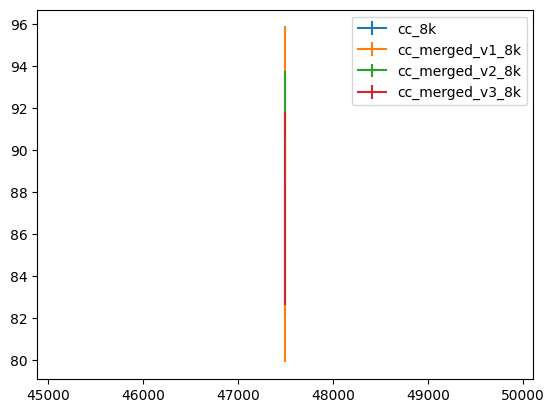

In [18]:
# plot the performance of 1b_8k on nq task
import matplotlib.pyplot as plt
INTERSTED_MODEL_NAME = 'tiny_LLaMA_1b_8k'
TASK_NAME = 'amazon'
df_1b_8k = df[df['model_name'] == INTERSTED_MODEL_NAME]
df_1b_8k = df_1b_8k[df_1b_8k['task'] == TASK_NAME]
# drop the columns that cannot be averaged
df_1b_8k = df_1b_8k.drop(columns=['model', 'task', 'model_name'])
# get the average over seeds, and standard deviation
df_1b_8k = df_1b_8k.groupby(['pretrain_dataset', 'step']).agg(['mean', 'std']).reset_index()
for dataset in df_1b_8k['pretrain_dataset'].unique():
    df_1b_8k_dataset = df_1b_8k[df_1b_8k['pretrain_dataset'] == dataset]
    plt.errorbar(df_1b_8k_dataset['step'], df_1b_8k_dataset['score']['mean'], yerr=df_1b_8k_dataset['score']['std'], label=dataset)
plt.legend()

### New version: based on the inputs itself

In [19]:
print(len(commands))

8


In [20]:
print(" ;".join(commands))

 sailctl job create eval1bamazoncc57 -g 1  --debug --image asia-docker.pkg.dev/sail-tpu-02/git-insea-io/common/image_registry/liuqian/tinyllama:v9   --command-line-args  ' bash /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/ ; bash single_task.sh tyzhu/tiny_LLaMA_1b_8k_cc_8k_iter-380000-ckpt-step-47500_hf amazon 57 '   ; sailctl job create eval1bamazonccmergedv142 -g 1  --debug --image asia-docker.pkg.dev/sail-tpu-02/git-insea-io/common/image_registry/liuqian/tinyllama:v9   --command-line-args  ' bash /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/ ; bash single_task.sh tyzhu/tiny_LLaMA_1b_8k_cc_merged_v1_8k_iter-380000-ckpt-step-47500_hf amazon 42 '   ; sailctl job create eval1bamazonccmergedv143 -g 1  --debug --image asia-docker.pkg.dev/sail-tpu-02/git-insea-io/common/image_registry/liuqian/tinyllama:v9   --command-line-args  ' bash /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/ ; b

In [73]:
d = eval_callables = {
    "nq": 1,
    "tq": 1,
    "wq": 1,
    "sst2": 1,
    "agnews": 1,
    "nq_obqa": 1,
    "hotpotqa": 1,
    "amazon": 1,
    "dbpedia": 1,
    "yelp": 1,
    "tweet_hate": 1,
    "tweet_offensive": 1,
    "squad": 1,
    "tq_obqa": 1,
}


In [74]:
d.keys()

dict_keys(['nq', 'tq', 'wq', 'sst2', 'agnews', 'nq_obqa', 'hotpotqa', 'amazon', 'dbpedia', 'yelp', 'tweet_hate', 'tweet_offensive', 'squad', 'tq_obqa'])

In [7]:
print(commands[0])

 sailctl job create eval1btqobqacc42 -g 1  --debug --image asia-docker.pkg.dev/sail-tpu-02/git-insea-io/common/image_registry/liuqian/tinyllama:v9   --command-line-args  ' bash /home/aiops/zhuty/start.sh ; cd /home/aiops/zhuty/tinyllama/scripts/fewshot_eval/ ; bash single_task.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_8k/iter-380000-ckpt-step-47500_hf tq_obqa 42 ' 


In [8]:
# read the output logs file
with open('/home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/logs', 'r') as file:
    data = file.readlines()
data = [ json.loads(x) for x in data]
print(data)

[{'task': 'nq', 'n_shot': 48, 'seed': 42, 'model': '/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_8k/iter-300000-ckpt-step-37500_hf', 'score': 3.9889196675900274}, {'task': 'nq', 'n_shot': 48, 'seed': 42, 'model': '/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_merged_v1_8k/iter-300000-ckpt-step-37500_hf', 'score': 4.1828254847645425}, {'task': 'nq', 'n_shot': 48, 'seed': 42, 'model': '/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_cc_merged_v2_8k/iter-300000-ckpt-step-37500_hf', 'score': 4.45983379501385}, {'task': 'nq', 'n_shot': 48, 'seed': 42, 'model': '/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_120M_8k_cc_8k/iter-400000-ckpt-step-100000_hf', 'score': 0.16620498614958448}, {'task': 'nq', 'n_shot': 48, 'seed': 42, 'model': '/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_cc_8k/iter-190000-ckpt-step-47500_hf', 'score': 1.10803324099723}, {'task': 'nq', 'n_shot': 48, 'seed': 42, 'model': '/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_cc_merged_v2_8k/iter-190000-ck

#### Misc utils files

In [89]:
for ds in ['cc', 'cc_merged_v1', 'cc_merged_v2']:
    folder_name = f"tiny_LLaMA_1b_8k_{ds}_8k-iter-380000-ckpt-step-47500_hf"
    print(f"rsync -ar --progress /s3/tinyllama/fewshot_eval_outputs/outputs/{folder_name}/tq* {folder_name}/ ")

rsync -ar --progress /s3/tinyllama/fewshot_eval_outputs/outputs/tiny_LLaMA_1b_8k_cc_8k-iter-380000-ckpt-step-47500_hf/tq* tiny_LLaMA_1b_8k_cc_8k-iter-380000-ckpt-step-47500_hf/ 
rsync -ar --progress /s3/tinyllama/fewshot_eval_outputs/outputs/tiny_LLaMA_1b_8k_cc_merged_v1_8k-iter-380000-ckpt-step-47500_hf/tq* tiny_LLaMA_1b_8k_cc_merged_v1_8k-iter-380000-ckpt-step-47500_hf/ 
rsync -ar --progress /s3/tinyllama/fewshot_eval_outputs/outputs/tiny_LLaMA_1b_8k_cc_merged_v2_8k-iter-380000-ckpt-step-47500_hf/tq* tiny_LLaMA_1b_8k_cc_merged_v2_8k-iter-380000-ckpt-step-47500_hf/ 


In [13]:
result = json.load(open("/home/aiops/zhuty/tinyllama/scripts/fewshot_eval/outputs/tiny_LLaMA_360M_8k_cc_8k-iter-160000-ckpt-step-40000_hf/nq_48_42_prompts_and_preds.json", 'r'))

In [14]:
result['preds']

['when the question: when the question: when the question: when the question:',
 "when he's when the air is on the air is when the air is",
 'when the question: when the question: when the question: when the question:',
 'when to the nca to the nca to the nca to the n',
 'when the basketball is the basketball is the basketball is the basketball is the basketball is',
 'when to the wake of the wight to the wake of the w',
 'when I is the time when the air is the air is the air is the',
 'when the air is the air in the air is the air in the air is',
 '19 1999 1999 19',
 '1994 1995 1996 ',
 '19 1999 2000 19',
 '199 1999 2000 1',
 '19 1999 1999 19',
 'when the question: when the question: when the question: when the question:',
 'when the nca is the nca is the nca is the nca',
 'who plays the game is the game of the game of the game of the game',
 '19 199 20 199 2',
 'who is the question: when the question: when the question: when the question',
 'when 100 in the bible 10 to the bible',
 '